In [1]:
from transform_data_representation import transform_dense_to_sparse_data
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from collections import Counter

Required directory 'C:\Users\Jorane Rogier\Documents\studie\year2\Research Internship\RecSysProject/output/' exists 
Required directory 'C:\Users\Jorane Rogier\Documents\studie\year2\Research Internship\RecSysProject/output/synthetic_data/' exists 
Required directory 'C:\Users\Jorane Rogier\Documents\studie\year2\Research Internship\RecSysProject/output/partitioned_data/' exists 


In [2]:
lastfm_path = "C:/Users/Jorane Rogier/Documents/studie/year2/Research Internship/RecSysProject/data/lastfm/threshold_artists_lfm1k-play-counts_Final.csv"
test_saving_file = 'test_img.png'

In [3]:
def load_implicit_user_item_matrix_lfm_All(lastfm_path, max_user=884, max_item=55686): #885 177023 max_user=992, max_item=70547 10000
    """
    this function loads the user x items matrix from the *old* movie lens data set.
    Both input parameter represent a threshold for the maximum user id or maximum item id
    The highest user id is  and the highest movie id is  for the original data set, however, the masked data
    set contains only 943 users and  items
    :return: user-item matrix
    """
    import os.path
    df = np.zeros(shape=(max_user, max_item)) #LastFM_10K_Features
    with open(lastfm_path, 'r') as f: 
        for line in f.readlines():
            user_id, movie_id, rating = line.split(",")
            user_id, movie_id, rating = int(user_id), int(movie_id), float(rating)
            df[user_id-1, movie_id-1] = 1

    return df

In [4]:
# Load implicit input data
#lastfm = pd.DataFrame(load_user_item_matrix_lfm_All(lastfm_path))

lastfm = pd.read_csv(lastfm_path, sep=',')
lastfm.columns = ['user', 'item', 'playCounts']

user_item_matrix = lastfm.pivot(*lastfm.columns)
user_item_matrix = user_item_matrix.fillna(0)
#user_item_matrix.columns = user_item_matrix.columns.astype(str)
df = pd.DataFrame(user_item_matrix)
print(df)

item  1      2      3      4      5      6      7      8      9      10     \
user                                                                         
1       0.0  855.0  779.0   12.0   18.0    8.0   15.0    6.0    6.0   20.0   
2       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3       2.0    0.0    2.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
4       0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
5     119.0    0.0    5.0    1.0    0.0    2.0    0.0    0.0    0.0    0.0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
880     0.0    0.0   34.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
881     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
882     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
883     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
884     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    

In [5]:
def compute_taus(df, minimum=0, maximum=10000000, rounding_tau=2, min_implicit=0):
    """
    Function to compute global ranking and user ranking, followed by kendall's tau
    INPUT: 
    * min, max -> items to be removed below/higher than these values
    * df -> input dataframe
    * rounding_tau -> rounding value for kendall's tau

    OUTPUT:
    * user_mainstreamnesses (tau, p-value)
    * taus 
    """
    # Create Global Item Ranking (GIR), looping over all artists (items), count how often the artist has been played
    GIR = {}
    for col in df:
        # does not take into account movies that have not been watched
        summed_rating = df[col].sum()
        nr_implicit = len(df[col].to_numpy().nonzero()[0])
        #print(len(nr_implicit[0]))
        #only take into account items that have been listened to a minimum and maximum amount of times
        if (summed_rating >= minimum) & (summed_rating <= maximum) & (nr_implicit>min_implicit):
            GIR[col] = summed_rating

    ranks_GIR = {k: v for k,v in sorted(GIR.items(), key=lambda item: item[1], reverse=True)}
    ranks_GIR_items = [*ranks_GIR]
    print(f'Length of ranks_GIR_items: {len(ranks_GIR_items)}')
    print(f'ranks_GIR: {ranks_GIR}')
    #return None
    
    # Compute user mainstreaminess (UM)
    user_mainstreamnesses = {}
    taus = []
    for uid in range(len(df)):
        user_dict = {}
        for item_id in df.columns:
            rating = df.iloc[uid][item_id]# uid here is not the true user_id (which is uid + 1), iloc needs integer, thus starting at 0
            # only take into account items that have been rated > minimum & < maximum times
            if item_id in GIR:
                user_dict[item_id] = rating
        
        # Rank the items for the user based on given ratings
        ranks_user = {k: v for k,v in sorted(user_dict.items(), key=lambda item: item[1], reverse=True)}
        ranks_user_items = [*ranks_user]
        
        # compute the mainstreaminess measure with Kendall's rank-order correlation
        tau, p_value = stats.kendalltau(ranks_GIR_items, ranks_user_items)
        user_mainstreamnesses[uid+1] = [tau, p_value] # Here, the actual user_id is used
        taus.append(round(tau, rounding_tau))
        
    print("Finished computing users' mainstreaminesses")
    
    # Plot taus to investigate the values
    plt.figure(0)
    plt.hist(taus)
    plt.xlabel("Kendall's tau")
    plt.ylabel("Counts")
    
    return user_mainstreamnesses, pd.Series(taus)

In [6]:
def compute_best_bandwidth(d):
    """
    Function to find the best bandwidth for kernel density estimation, given input d.
    """
    bandwidths = 10 ** np.linspace(-1, 1, 100)
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                        {'bandwidth': bandwidths})
    grid.fit(d[:, None])
    print(grid.best_params_)
    return grid.best_params_

In [7]:
def plot_distribution(df_orig, df_syn):   
    plt.plot(range(len(df_orig)), df_orig['counts'], label='Original')
    plt.fill_between(range(len(df_orig)), df_orig['counts'], color='#539ecd', alpha=0.5)

    plt.plot(range(len(df_syn)), df_syn['counts'], label='CTGAN')
    plt.fill_between(range(len(df_syn)), df_syn['counts'], color='#4cad6e', alpha=0.5)
    plt.legend(loc='upper right')


In [8]:
def transform_sparse_to_dense_data(sparse_df):
    if 'total' in sparse_df.columns:
        sparse_df = sparse_df.reset_index(drop=True)
        sparse_df = sparse_df.drop(labels='total', axis=1)
        print(sparse_df.columns)
    transformed_data = []
    for uid in range(len(sparse_df)):
        for item_id in sparse_df.columns:
            rating = sparse_df.iloc[uid][item_id]
            #print(f"user {uid} - item: {item_id} - rating: {rating}")
            if rating != 0:
                user_id = int(uid)+1
                sample = [user_id, int(item_id), str(int(rating))]
                transformed_data.append(sample)
            
    df = pd.DataFrame(transformed_data, columns =['user', 'item', 'rating'])
    return df

In [9]:
def get_division_characteristics(user_mainstreamnesses, plot_saving_filename, csv_saving_filename, tau_cutoff=0.02):
    # Get the user-ids which have tau < tau_cutoff (beyond mainstream users, bmu)    
    bmu = [k for k, v in user_mainstreamnesses.items() if float(v[0]) < float(tau_cutoff)] # For some reason does not work?
    #print(user_mainstreamnesses.items())
    print(len(bmu))
    
    # Get the user-ids which have tau >= tau_cutoff (mainstream users, mu)
    mu = [k for k, v in user_mainstreamnesses.items() if float(v[0]) >= tau_cutoff]
    print(len(mu))
    
    # Since the user-id's started at 1, but for indexing we start at 0, 
    # we subtract 1 from all elements in the lists
    bmu[:] = [n-1 for n in bmu]
    mu[:] = [n-1 for n in mu]
    
    df_bmu = df.iloc[bmu]
    df_bmu = df_bmu[df_bmu.columns].astype(int)
    df_mu = df.iloc[mu]
    df_mu = df_mu[df_mu.columns].astype(int)
    # concat both dataframes vertically
    df_all = pd.concat([df_bmu, df_mu], axis=0)
    df_all = df_all[df_all.columns].astype(int)
    
    # Save locally as csv file
    df_bmu.to_csv(f'orig_sparse_beyond_mainstream_{csv_saving_filename}.csv')
    df_all.to_csv(f'orig_sparse_all_{csv_saving_filename}.csv')
    
    # check user distribution
    df_bmu_dense = transform_sparse_to_dense_data(df_bmu)
    df_mu_dense = transform_sparse_to_dense_data(df_mu)

    '''df_bmu_counts = df_bmu_dense.groupby('item').size().reset_index(name='counts')
    df_bmu_counts = df_bmu_counts.sort_values(by='counts', ascending=False)
    df_mu_counts = df_mu_dense.groupby('item').size().reset_index(name='counts')
    df_mu_counts = df_mu_counts.sort_values(by='counts', ascending=False)

    plot_distribution(df_bmu_counts, df_mu_counts)'''
    
    # samples = synthetic 
    # data = original

    n_users_bmu = df_bmu_dense.user.unique().shape[0]
    n_items_bmu = df_bmu_dense.item.unique().shape[0]
    n_usersd_mu = df_mu_dense.user.unique().shape[0]
    n_itemsd_mu = df_mu_dense.item.unique().shape[0] 
    # n_userrd = random.userid.unique().shape[0]
    # n_itemsrd = random.itemid.unique().shape[0]

    # Sort movie ratings in decreasing order of ratings
    data_movieratings = Counter(df_mu_dense['user'])
    ctr_movieratings = Counter(df_bmu_dense['user'])
    # ran_movieratings = Counter(random['userid'])

    #plt.xticks(rankings['movieId'])
    plt.figure(figsize=(6,5))
    plt.grid(linewidth=0.4, color='lightgray') 
    #plt.bar(np.arange(n_users_bmu),sorted(ctr_movieratings.values(),reverse = True), edgecolor='orchid', color='None', alpha=0.4)# color= "orchid")
    # plt.bar(np.arange(n_userrd),sorted(ran_movieratings.values(),reverse = True), edgecolor='deepskyblue', color='None')# color= "deepskyblue")
    plt.plot(np.arange(n_users_bmu),sorted(ctr_movieratings.values(),reverse = True), label='Beyond mainstream', color='blue')# color= "orchid")
    plt.fill_between(range(len(np.arange(n_users_bmu))),sorted(ctr_movieratings.values(),reverse = True), color='#0868ac', alpha=0.5)
    #plt.bar(np.arange(n_usersd_mu),sorted(data_movieratings.values(),reverse = True), edgecolor='bisque', color='None', alpha=0.4)# color= "bisque")
    plt.plot(np.arange(n_usersd_mu),sorted(data_movieratings.values(),reverse = True), label='Mainstream', color='green')# color= "bisque")
    plt.fill_between(range(len(np.arange(n_usersd_mu))), sorted(data_movieratings.values(),reverse = True), color='#bae4bc', alpha=0.5)
    
    plt.title(f'Distribution of ratings among users {csv_saving_filename}', size= 20, fontweight='bold')
    plt.xlabel('Users', size= 20)#, fontweight='bold')
    plt.ylabel('Number of ratings', size= 20)#, fontweight='bold')
    plt.grid('on')
    #plt.legend(["Beyond-mainstream", "Mainstream"], prop={'size': 18})
    plt.legend(loc='upper right')
    plt.savefig (f"{plot_saving_filename}.pdf")
    plt.show()
    
    df_bmu_dense.to_csv(f'orig_dense_beyond_mainstream_{csv_saving_filename}.csv')
    df_mu_dense.to_csv(f'orig_dense_mainstream_{csv_saving_filename}.csv')
    
    # compute non-zero values per row for both dataframes
    df_bmu['total'] = df.gt(0).sum(axis=1)
    df_mu['total'] = df.gt(0).sum(axis=1)
        
        
    # Compare the characteristics.
    data = {'Characteristic': ['Min. #Ratings', 'Max. #Ratings', 'Mean #Ratings', '# Users'],
                'Beyond-mainstream': [df_bmu['total'].min(), df_bmu['total'].max(), df_bmu['total'].mean(), len(bmu)],
                'Mainstream': [df_mu['total'].min(), df_mu['total'].max(), df_mu['total'].mean(), len(mu)]}

    compare_df = pd.DataFrame(data)
    print(compare_df)
    return compare_df
    

## Look into data characteristics when removing items with < 600 playCounts

### Investigate taus

Length of ranks_GIR_items: 4093
ranks_GIR: {71: 107532.0, 545: 93785.0, 1473: 81296.0, 563: 59664.0, 3078: 56367.0, 1510: 55218.0, 118: 53406.0, 574: 51830.0, 751: 49845.0, 2543: 48986.0, 1618: 46969.0, 1226: 45891.0, 712: 44921.0, 795: 44611.0, 1495: 44283.0, 429: 43197.0, 777: 42674.0, 3316: 42074.0, 870: 41301.0, 895: 40755.0, 746: 38266.0, 762: 37360.0, 49: 37295.0, 1198: 37187.0, 884: 37060.0, 457: 36539.0, 1390: 36279.0, 236: 36111.0, 1217: 34940.0, 731: 34802.0, 1668: 33796.0, 1004: 32633.0, 1224: 32202.0, 925: 32136.0, 1349: 32096.0, 1660: 31959.0, 761: 31567.0, 1879: 31439.0, 1703: 30932.0, 920: 30737.0, 2655: 30673.0, 782: 30584.0, 583: 30469.0, 600: 29918.0, 591: 29877.0, 1318: 29629.0, 2458: 29567.0, 1279: 29517.0, 546: 29232.0, 760: 29038.0, 1308: 28230.0, 540: 28064.0, 739: 28005.0, 1802: 27923.0, 4443: 27599.0, 794: 27347.0, 1532: 27008.0, 679: 25815.0, 25644: 25813.0, 1634: 25662.0, 595: 25656.0, 542: 25493.0, 84: 25318.0, 891: 25036.0, 565: 24894.0, 1147: 24703.0, 2272

Finished computing users' mainstreaminesses


<ipython-input-17-1d79585076c0>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  grid.fit(d[:, None])


{'bandwidth': 0.1}


<ipython-input-78-42114194c19a>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde.fit(taus_df[:, None])


(-0.001, 40.0)

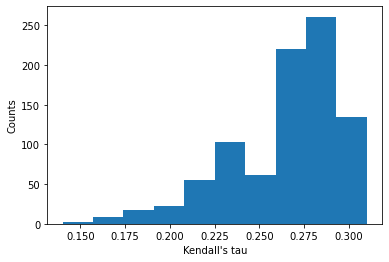

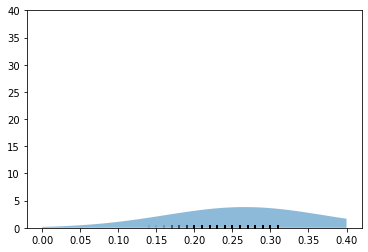

In [78]:
user_mainstreamnesses, taus_df = compute_taus(df, minimum=600, min_implicit=0)
best_bandwidth = compute_best_bandwidth(taus_df)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=best_bandwidth['bandwidth'], kernel='gaussian')
x_d2 = np.linspace(0, 0.4, 1000)

kde.fit(taus_df[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d2[:, None])

plt.figure(1)
plt.fill_between(x_d2, np.exp(logprob), alpha=0.5)
plt.plot(taus_df, np.full_like(taus_df, -0.01), '|k', markeredgewidth=0.2)
plt.ylim(-0.001, 40)

#### Divide users into two groups, based on mainstreaminess score, and compare group-size characteristics

In [79]:
tau_cutoff = 0.26
prep = 'playcounts_l600'#preprocessing: nothing removed

plot_saving_filename = f"plot_user_distribution_tau_{tau_cutoff}_{prep}_lastfm"
csv_saving_filename = f"tau_{tau_cutoff}_{prep}_lastfm"

compare_df = get_division_characteristics(user_mainstreamnesses, plot_saving_filename, csv_saving_filename, tau_cutoff)

309
575


KeyboardInterrupt: 

## Look into data characteristics when removing items with < 1000 playCounts

In [ ]:
user_mainstreamnesses, taus_df = compute_taus(df, minimum=1000, min_implicit=0)
best_bandwidth = compute_best_bandwidth(taus_df)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=best_bandwidth['bandwidth'], kernel='gaussian')
x_d2 = np.linspace(0, 0.4, 1000)

kde.fit(taus_df[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d2[:, None])

plt.figure(1)
plt.fill_between(x_d2, np.exp(logprob), alpha=0.5)
plt.plot(taus_df, np.full_like(taus_df, -0.01), '|k', markeredgewidth=0.2)
plt.ylim(-0.001, 40)

In [ ]:
tau_cutoff = X
prep = 'playcounts_l1000'#preprocessing: nothing removed

plot_saving_filename = f"plot_user_distribution_tau_{tau_cutoff}_{prep}_lastfm"
csv_saving_filename = f"tau_{tau_cutoff}_{prep}_lastfm"

compare_df = get_division_characteristics(user_mainstreamnesses, plot_saving_filename, csv_saving_filename, tau_cutoff)

## Look into data characteristics when removing items with < 60 user-listeners

Length of ranks_GIR_items: 2180
ranks_GIR: {71: 107532.0, 545: 93785.0, 1473: 81296.0, 563: 59664.0, 3078: 56367.0, 1510: 55218.0, 118: 53406.0, 574: 51830.0, 751: 49845.0, 2543: 48986.0, 1618: 46969.0, 1226: 45891.0, 712: 44921.0, 795: 44611.0, 1495: 44283.0, 429: 43197.0, 777: 42674.0, 3316: 42074.0, 870: 41301.0, 895: 40755.0, 746: 38266.0, 762: 37360.0, 49: 37295.0, 1198: 37187.0, 884: 37060.0, 457: 36539.0, 1390: 36279.0, 236: 36111.0, 1217: 34940.0, 731: 34802.0, 1668: 33796.0, 1004: 32633.0, 1224: 32202.0, 925: 32136.0, 1349: 32096.0, 1660: 31959.0, 761: 31567.0, 1879: 31439.0, 1703: 30932.0, 920: 30737.0, 2655: 30673.0, 782: 30584.0, 583: 30469.0, 600: 29918.0, 591: 29877.0, 1318: 29629.0, 2458: 29567.0, 1279: 29517.0, 546: 29232.0, 760: 29038.0, 1308: 28230.0, 540: 28064.0, 739: 28005.0, 1802: 27923.0, 4443: 27599.0, 794: 27347.0, 1532: 27008.0, 679: 25815.0, 1634: 25662.0, 595: 25656.0, 542: 25493.0, 84: 25318.0, 891: 25036.0, 565: 24894.0, 1147: 24703.0, 2272: 24510.0, 1850:

Finished computing users' mainstreaminesses


<ipython-input-6-1d79585076c0>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  grid.fit(d[:, None])


{'bandwidth': 0.1}


<ipython-input-10-17e38edbc6b8>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde.fit(taus_df[:, None])


(-0.001, 40.0)

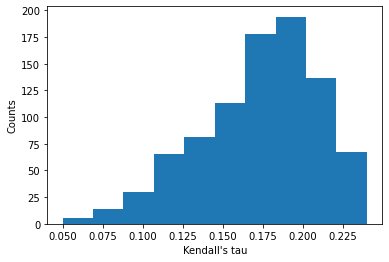

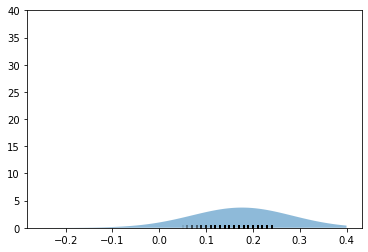

In [10]:
user_mainstreamnesses, taus_df = compute_taus(df, minimum=0, min_implicit=60)
best_bandwidth = compute_best_bandwidth(taus_df)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=best_bandwidth['bandwidth'], kernel='gaussian')
x_d2 = np.linspace(-0.25, 0.4, 1000)

kde.fit(taus_df[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d2[:, None])

plt.figure(1)
plt.fill_between(x_d2, np.exp(logprob), alpha=0.5)
plt.plot(taus_df, np.full_like(taus_df, -0.01), '|k', markeredgewidth=0.2)
plt.ylim(-0.001, 40)

433
451


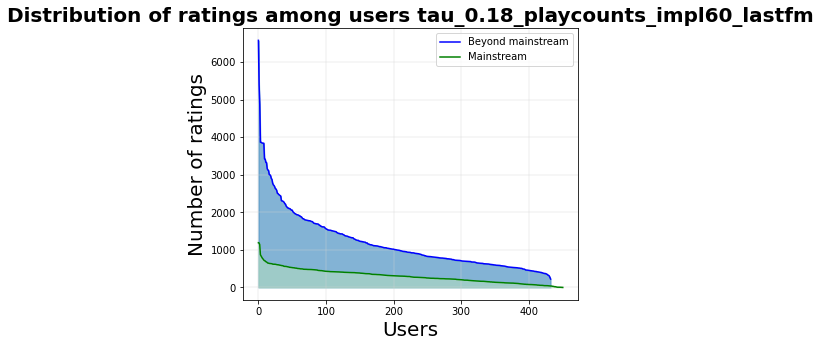

  Characteristic  Beyond-mainstream   Mainstream
0  Min. #Ratings         224.000000     1.000000
1  Max. #Ratings        6579.000000  1191.000000
2  Mean #Ratings        1199.311778   302.940133
3        # Users         433.000000   451.000000


In [11]:
tau_cutoff = 0.18
prep = 'playcounts_impl60'#preprocessing: nothing removed

plot_saving_filename = f"plot_user_distribution_tau_{tau_cutoff}_{prep}_lastfm"
csv_saving_filename = f"tau_{tau_cutoff}_{prep}_lastfm"

compare_df = get_division_characteristics(user_mainstreamnesses, plot_saving_filename, csv_saving_filename, tau_cutoff)

## Look into data characteristics when removing items < 50 ratings

Length of ranks_GIR_items: 604
Finished computing users' mainstreaminesses


<ipython-input-6-1d79585076c0>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  grid.fit(d[:, None])


{'bandwidth': 0.1}


<ipython-input-20-8ea21f7a5a75>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde.fit(taus_df[:, None])


(-0.001, 40.0)

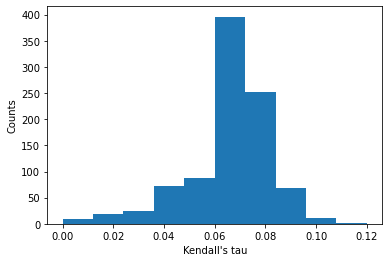

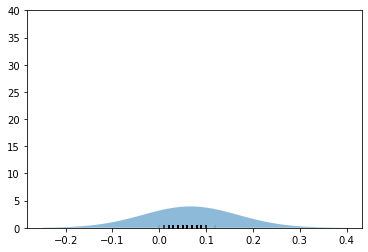

In [20]:
user_mainstreamnesses, taus_df = compute_taus(df, minimum=50)
best_bandwidth = compute_best_bandwidth(taus_df)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=best_bandwidth['bandwidth'], kernel='gaussian')
x_d2 = np.linspace(-0.25, 0.4, 1000)

kde.fit(taus_df[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d2[:, None])

plt.figure(1)
plt.fill_between(x_d2, np.exp(logprob), alpha=0.5)
plt.plot(taus_df, np.full_like(taus_df, -0.01), '|k', markeredgewidth=0.2)
plt.ylim(-0.001, 40)

### Divide users into two groups, based on mainstreaminess score, and compare group-size characteristics

259
684
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)


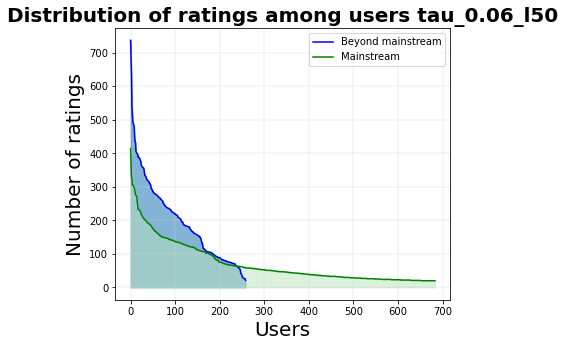

  Characteristic  Beyond-mainstream  Mainstream
0  Min. #Ratings          22.000000   21.000000
1  Max. #Ratings         738.000000  415.000000
2  Mean #Ratings         197.675676   72.726608
3        # Users         259.000000  684.000000


In [21]:
tau_cutoff = 0.06
prep = 'l50'#preprocessing: nothing removed

plot_saving_filename = f"plot_user_distribution_tau_{tau_cutoff}_{prep}"
csv_saving_filename = f"tau_{tau_cutoff}_{prep}"

compare_df = get_division_characteristics(user_mainstreamnesses, plot_saving_filename, csv_saving_filename, tau_cutoff)

## Look into data characteristics when removing items < 100 ratings

Length of ranks_GIR_items: 339
Finished computing users' mainstreaminesses


<ipython-input-6-1d79585076c0>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  grid.fit(d[:, None])


{'bandwidth': 0.1}


<ipython-input-22-4b13de2c5ab0>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde.fit(taus_df[:, None])


(-0.001, 40.0)

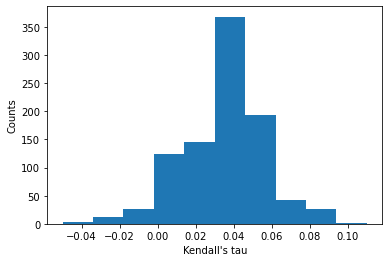

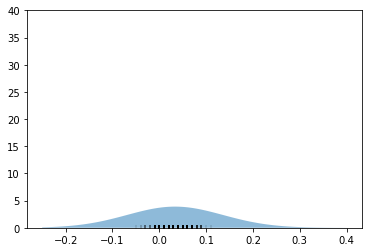

In [22]:
user_mainstreamnesses, taus_df = compute_taus(df, minimum=100)
best_bandwidth = compute_best_bandwidth(taus_df)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=best_bandwidth['bandwidth'], kernel='gaussian')
x_d2 = np.linspace(-0.25, 0.4, 1000)

kde.fit(taus_df[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d2[:, None])

plt.figure(1)
plt.fill_between(x_d2, np.exp(logprob), alpha=0.5)
plt.plot(taus_df, np.full_like(taus_df, -0.01), '|k', markeredgewidth=0.2)
plt.ylim(-0.001, 40)

### Divide users into two groups, based on mainstreaminess score, and compare group-size characteristics

898
45
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)


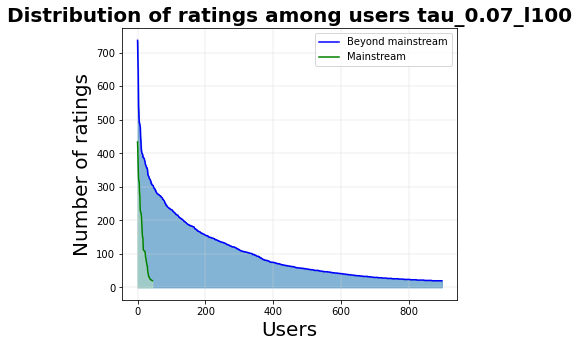

  Characteristic  Beyond-mainstream  Mainstream
0  Min. #Ratings          21.000000   21.000000
1  Max. #Ratings         738.000000  435.000000
2  Mean #Ratings         105.566815  136.533333
3        # Users         898.000000   45.000000


In [23]:
tau_cutoff = 0.07
prep = 'l100'#preprocessing: nothing removed

plot_saving_filename = f"plot_user_distribution_tau_{tau_cutoff}_{prep}"
csv_saving_filename = f"tau_{tau_cutoff}_{prep}"

compare_df = get_division_characteristics(user_mainstreamnesses, plot_saving_filename, csv_saving_filename, tau_cutoff)

## Look into data characteristics when removing items < 20 & > 200 ratings

Length of ranks_GIR_items: 822
Finished computing users' mainstreaminesses


<ipython-input-6-1d79585076c0>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  grid.fit(d[:, None])


{'bandwidth': 0.1}


<ipython-input-24-0b253c61dd5c>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde.fit(taus_df[:, None])


(-0.001, 40.0)

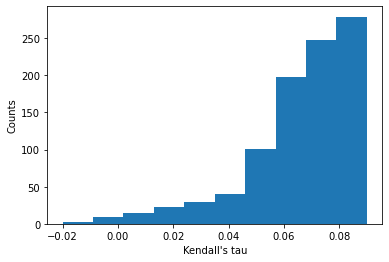

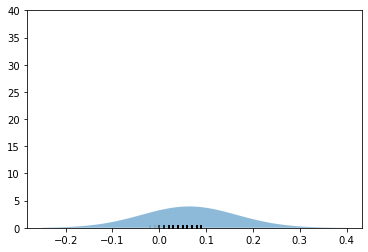

In [24]:
user_mainstreamnesses, taus_df = compute_taus(df, minimum=20, maximum=200)
best_bandwidth = compute_best_bandwidth(taus_df)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=best_bandwidth['bandwidth'], kernel='gaussian')
x_d2 = np.linspace(-0.25, 0.4, 1000)

kde.fit(taus_df[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d2[:, None])

plt.figure(1)
plt.fill_between(x_d2, np.exp(logprob), alpha=0.5)
plt.plot(taus_df, np.full_like(taus_df, -0.01), '|k', markeredgewidth=0.2)
plt.ylim(-0.001, 40)

### Divide users into two groups, based on mainstreaminess score, and compare group-size characteristics

303
640
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)


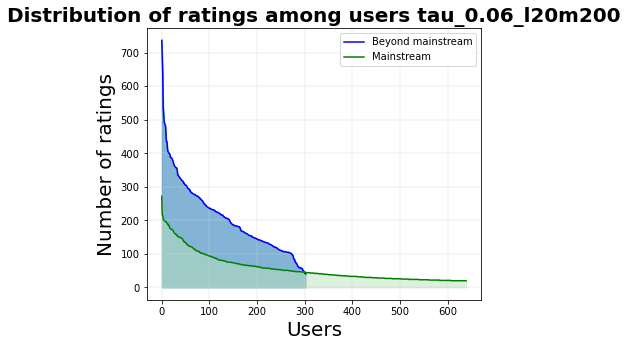

  Characteristic  Beyond-mainstream  Mainstream
0  Min. #Ratings          41.000000   21.000000
1  Max. #Ratings         738.000000  273.000000
2  Mean #Ratings         209.877888   58.359375
3        # Users         303.000000  640.000000


In [25]:
tau_cutoff = 0.06
prep = 'l20m200'#preprocessing: nothing removed

plot_saving_filename = f"plot_user_distribution_tau_{tau_cutoff}_{prep}"
csv_saving_filename = f"tau_{tau_cutoff}_{prep}"

compare_df = get_division_characteristics(user_mainstreamnesses, plot_saving_filename, csv_saving_filename, tau_cutoff)

## Look into data characteristics when removing items > 100 ratings

Length of ranks_GIR_items: 1348
Finished computing users' mainstreaminesses


<ipython-input-6-1d79585076c0>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  grid.fit(d[:, None])


{'bandwidth': 0.1}


<ipython-input-26-2254ba162342>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde.fit(taus_df[:, None])


(-0.001, 40.0)

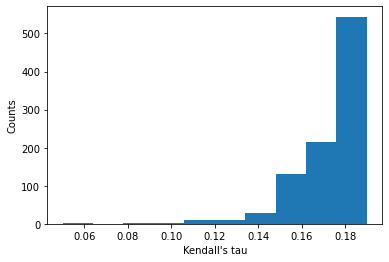

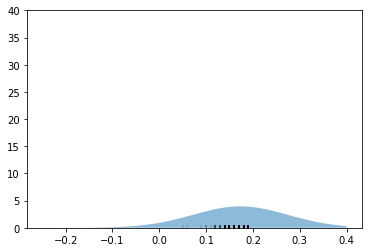

In [26]:
user_mainstreamnesses, taus_df = compute_taus(df, minimum=0, maximum=100)
best_bandwidth = compute_best_bandwidth(taus_df)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=best_bandwidth['bandwidth'], kernel='gaussian')
x_d2 = np.linspace(-0.25, 0.4, 1000)

kde.fit(taus_df[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d2[:, None])

plt.figure(1)
plt.fill_between(x_d2, np.exp(logprob), alpha=0.5)
plt.plot(taus_df, np.full_like(taus_df, -0.01), '|k', markeredgewidth=0.2)
plt.ylim(-0.001, 40)

### Divide users into two groups, based on mainstreaminess score, and compare group-size characteristics

646
297
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)


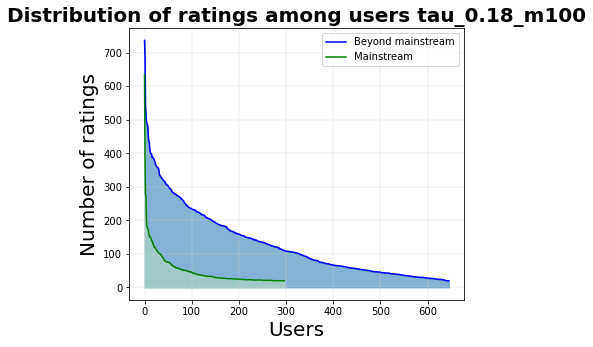

  Characteristic  Beyond-mainstream  Mainstream
0  Min. #Ratings          21.000000   21.000000
1  Max. #Ratings         738.000000  637.000000
2  Mean #Ratings         132.422601   51.845118
3        # Users         646.000000  297.000000


In [27]:
tau_cutoff = 0.18
prep = 'm100'#preprocessing: nothing removed

plot_saving_filename = f"plot_user_distribution_tau_{tau_cutoff}_{prep}"
csv_saving_filename = f"tau_{tau_cutoff}_{prep}"

compare_df = get_division_characteristics(user_mainstreamnesses, plot_saving_filename, csv_saving_filename, tau_cutoff)

## Look into data characteristics when removing items > 200 ratings

Length of ranks_GIR_items: 1565
Finished computing users' mainstreaminesses


<ipython-input-6-1d79585076c0>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  grid.fit(d[:, None])


{'bandwidth': 0.1}


<ipython-input-28-fbe1ccd2bcbb>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde.fit(taus_df[:, None])


(-0.001, 40.0)

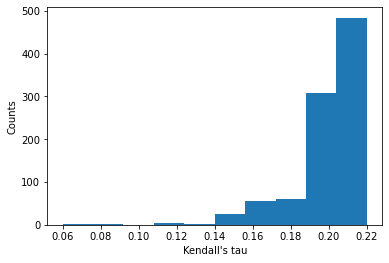

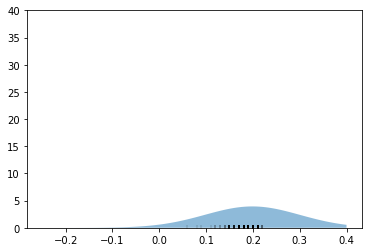

In [28]:
user_mainstreamnesses, taus_df = compute_taus(df, minimum=0, maximum=200)
best_bandwidth = compute_best_bandwidth(taus_df)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=best_bandwidth['bandwidth'], kernel='gaussian')
x_d2 = np.linspace(-0.25, 0.4, 1000)

kde.fit(taus_df[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d2[:, None])

plt.figure(1)
plt.fill_between(x_d2, np.exp(logprob), alpha=0.5)
plt.plot(taus_df, np.full_like(taus_df, -0.01), '|k', markeredgewidth=0.2)
plt.ylim(-0.001, 40)

### Divide users into two groups, based on mainstreaminess score, and compare group-size characteristics

25
918
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)


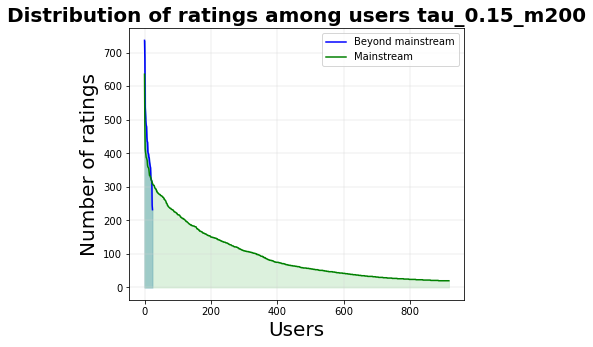

  Characteristic  Beyond-mainstream  Mainstream
0  Min. #Ratings              233.0   21.000000
1  Max. #Ratings              738.0  637.000000
2  Mean #Ratings              419.2   98.543573
3        # Users               25.0  918.000000


In [29]:
tau_cutoff = 0.15
prep = 'm200'#preprocessing: nothing removed

plot_saving_filename = f"plot_user_distribution_tau_{tau_cutoff}_{prep}"
csv_saving_filename = f"tau_{tau_cutoff}_{prep}"

compare_df = get_division_characteristics(user_mainstreamnesses, plot_saving_filename, csv_saving_filename, tau_cutoff)